### 导入相关库

In [3]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import keras
import tensorflow as tf

### GPU按需使用

In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

### 屏蔽warnings

In [5]:
tf.logging.set_verbosity(tf.logging.ERROR)

### 加载数据

In [6]:
def get_label(file_path):
    file_name = os.path.split(file_path)[-1]
    label = file_name.split('_')[1]
    if label == 'drown':
        return 1
    else:
        return 0

In [7]:
def sequence_padding(array, maxlen, value):
    num_timesteps, num_dims = array.shape 
    padding = value * np.ones((maxlen-num_timesteps, num_dims))
    new_array = np.concatenate([array, padding], axis=0)
    
    return new_array

In [8]:
def vector2angle(v1, v2):
    a = np.dot(v1, v2)
    b = np.linalg.norm(v1) * np.linalg.norm(v2) + 0.0000000001
    #angle = np.arccos(a/b) * 180 / np.pi
    return a/b #输出为0-1 cos

In [9]:
def coordinate2angle(data):
    angles = np.zeros((data.shape[0],8))
    for i in range(len(data)):
        coords = data[i]
        locations = {
            "Nose":coords[:2],
            "LShoulder": coords[10:12],
            "RShoulder":coords[12:14],
            "LElbow":coords[14:16],
            "RElbow":coords[16:18],
            "LWrist":coords[18:20],
            "RWrist":coords[20:22],
            "LHip":coords[22:24],
            "RHip":coords[24:26],
            "LKnee":coords[26:28],
            "RKnee":coords[28:30],
            "LAnkle":coords[30:32],
            "RAnkle":coords[32:34]
        } #提取出数值
    
        skeletons = {
            "LShoulder": locations['RShoulder'] - locations['LShoulder'],
            "RShoulder": locations['LShoulder'] - locations['RShoulder'],
            "LUpperArm": locations['LElbow']    - locations['LShoulder'],
            "RUpperArm": locations['RElbow']    - locations['RShoulder'],
            "LLowerArm": locations['LWrist']    - locations['LElbow'],
            "RLowerArm": locations['RWrist']    - locations['RElbow'],
            "LHip":      locations['RHip']      - locations['LHip'],
            "RHip":      locations['LHip']      - locations['RHip'],
            "LUpperLeg": locations['LKnee']     - locations['LHip'],
            "RUpperLeg": locations['RKnee']     - locations['RHip'],
            "LLowerLeg": locations['LAnkle']    - locations['LKnee'],
            "RLowerLeg": locations['RAnkle']    - locations['RKnee'],
        } #向量
    
        angle = np.zeros(8)
        angle[0] =  vector2angle(skeletons['LShoulder'], skeletons['LUpperArm'])
        angle[1] =  vector2angle(skeletons['RShoulder'], skeletons['RUpperArm'])
        angle[2] =  vector2angle(skeletons['LUpperArm'], skeletons['LLowerArm'])
        angle[3] =  vector2angle(skeletons['RUpperArm'], skeletons['RLowerArm'])
        angle[4] =  vector2angle(skeletons['LUpperLeg'], skeletons['LHip'])
        angle[5] =  vector2angle(skeletons['RUpperLeg'], skeletons['RHip'])
        angle[6] =  vector2angle(skeletons['LUpperLeg'], skeletons['LLowerLeg'])
        angle[7] =  vector2angle(skeletons['RUpperLeg'], skeletons['RLowerLeg'])
    
        angles[i] = angle
    return angles

In [10]:
def centralize_coordinate(data):
    new_coords = np.empty_like(data)
    for i in range(len(data)):
        coords = data[i]
        for j in range(2, len(coords)):
            if j % 2 == 0:
                coords[j] -= coords[0]
            else:
                coords[j] -= coords[1]
        coords[0] = 0
        coords[1] = 0
        new_coords[i] = coords
        
    return new_coords

In [21]:
def load_dataset(input_dir):
    datas= []
    labels = []
    
    for file in os.listdir(input_dir):
        if file == '.ipynb_checkpoints':
            continue
        else:
            path = os.path.join(input_dir, file)
            data = np.loadtxt(path, ndmin=2)
        #data = centralize_coordinate(data)
        #data = coordinate2angle(data)
            data = sequence_padding(data, maxlen=30, value=-1)#不够60行的话补-1，最长的frame是-1
            label = get_label(path)
            datas.append(data)
            labels.append(label)
        
    return np.array(datas), np.array(labels)

In [22]:
train_x, train_y = load_dataset('data')

In [23]:
train_y.shape

(107,)

### 构建LSTM

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Masking, Dropout, BatchNormalization

In [25]:
model = Sequential()

model.add(Masking(mask_value=-1,input_shape=(30,34))) #此函数定义是，如果后面是-1就不参与计算

#model.add(LSTM(16,dropout=0.2,recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(128,dropout=0.2,recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(128,dropout=0.2,recurrent_dropout=0.2, return_sequences=False))

model.add(Dense(64,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 30, 34)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 128)           83456     
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 224,353
Trainable params: 224,353
Non-trainable params: 0
________________________________________________

### 设置Callbacks

In [26]:
from keras.callbacks import LearningRateScheduler

def scheduler(epoch):
    # 每隔10个epoch，学习率减小为原来的1/10
    if epoch % 10 == 0 and epoch != 0:
        lr = K.get_value(model.optimizer.lr)
        
        K.set_value(model.optimizer.lr, lr * 0.95)
    #print(K.get_value(model.optimizer.lr))
    return K.get_value(model.optimizer.lr)

reduce_lr = LearningRateScheduler(scheduler)

In [27]:
from keras.callbacks import ModelCheckpoint, CSVLogger

#filepath = 'model.hdf5'
#checkpoint = ModelCheckpoint(filepath, monitor='train_acc', verbose=0, save_best_only=True, mode='auto')
import keras.backend as K
from keras.callbacks import LearningRateScheduler



filename = 'train_log.csv'
csv_logger = CSVLogger(filename, separator=',', append=True)



In [28]:
callbacks_list = [csv_logger, reduce_lr]

### 模型编译

In [29]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### 训练模型

In [30]:
hist = model.fit(x=train_x, y=train_y, batch_size=16,epochs=1000, verbose=1, callbacks=callbacks_list, validation_split=0.2)

Train on 85 samples, validate on 22 samples
Epoch 1/1000
85/85 [==============================] - 9s 101ms/step - loss: 0.6603 - acc: 0.6235 - val_loss: 0.6495 - val_acc: 0.5455
Epoch 2/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.5843 - acc: 0.6471 - val_loss: 0.5664 - val_acc: 0.5909
Epoch 3/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.6079 - acc: 0.6118 - val_loss: 0.5252 - val_acc: 0.7727
Epoch 4/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.5813 - acc: 0.7176 - val_loss: 0.4609 - val_acc: 0.8182
Epoch 5/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.5910 - acc: 0.6471 - val_loss: 0.4903 - val_acc: 0.7727
Epoch 6/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.5121 - acc: 0.6941 - val_loss: 0.4452 - val_acc: 0.8182
Epoch 7/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.4872 - acc: 0.7529 - val_loss: 0.3911 - val_acc: 0.9091
Epoch 8/1000
85/85 [==========

85/85 [==============================] - 0s 5ms/step - loss: 0.3848 - acc: 0.8353 - val_loss: 0.2220 - val_acc: 0.9091
Epoch 63/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.3314 - acc: 0.8471 - val_loss: 0.2364 - val_acc: 0.9091
Epoch 64/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.4107 - acc: 0.7647 - val_loss: 0.2188 - val_acc: 0.9545
Epoch 65/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.3831 - acc: 0.8118 - val_loss: 0.2465 - val_acc: 0.8636
Epoch 66/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.3810 - acc: 0.8471 - val_loss: 0.2259 - val_acc: 0.9545
Epoch 67/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.4267 - acc: 0.8118 - val_loss: 0.2285 - val_acc: 0.9091
Epoch 68/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.3296 - acc: 0.8941 - val_loss: 0.2697 - val_acc: 0.8636
Epoch 69/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.3958 -

85/85 [==============================] - 0s 5ms/step - loss: 0.3193 - acc: 0.8588 - val_loss: 0.1519 - val_acc: 0.9545
Epoch 124/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.3049 - acc: 0.8588 - val_loss: 0.1791 - val_acc: 0.9545
Epoch 125/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1889 - acc: 0.9294 - val_loss: 0.1560 - val_acc: 0.9545
Epoch 126/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.3043 - acc: 0.8471 - val_loss: 0.1574 - val_acc: 0.9545
Epoch 127/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.2928 - acc: 0.8471 - val_loss: 0.1323 - val_acc: 0.9545
Epoch 128/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.2398 - acc: 0.8941 - val_loss: 0.1427 - val_acc: 0.9545
Epoch 129/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.2850 - acc: 0.8941 - val_loss: 0.1288 - val_acc: 0.9545
Epoch 130/1000
85/85 [==============================] - 0s 5ms/step - loss: 0

85/85 [==============================] - 0s 5ms/step - loss: 0.2104 - acc: 0.9294 - val_loss: 0.0764 - val_acc: 0.9545
Epoch 185/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1586 - acc: 0.9412 - val_loss: 0.0834 - val_acc: 0.9545
Epoch 186/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.3268 - acc: 0.8941 - val_loss: 0.0981 - val_acc: 0.9545
Epoch 187/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.2436 - acc: 0.8941 - val_loss: 0.0849 - val_acc: 0.9545
Epoch 188/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1610 - acc: 0.9412 - val_loss: 0.1169 - val_acc: 0.9545
Epoch 189/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1783 - acc: 0.9176 - val_loss: 0.1399 - val_acc: 0.9545
Epoch 190/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1884 - acc: 0.9294 - val_loss: 0.1474 - val_acc: 0.9545
Epoch 191/1000
85/85 [==============================] - 0s 5ms/step - loss: 0

85/85 [==============================] - 0s 5ms/step - loss: 0.1316 - acc: 0.9647 - val_loss: 0.1188 - val_acc: 0.9545
Epoch 246/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1457 - acc: 0.9412 - val_loss: 0.1151 - val_acc: 0.9545
Epoch 247/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1943 - acc: 0.9294 - val_loss: 0.1176 - val_acc: 0.9545
Epoch 248/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1605 - acc: 0.9529 - val_loss: 0.1393 - val_acc: 0.9091
Epoch 249/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1720 - acc: 0.9294 - val_loss: 0.1367 - val_acc: 0.9091
Epoch 250/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1570 - acc: 0.8941 - val_loss: 0.1221 - val_acc: 0.9545
Epoch 251/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.2935 - acc: 0.8706 - val_loss: 0.1870 - val_acc: 0.9545
Epoch 252/1000
85/85 [==============================] - 0s 5ms/step - loss: 0

85/85 [==============================] - 0s 5ms/step - loss: 0.1345 - acc: 0.9412 - val_loss: 0.1178 - val_acc: 0.9545
Epoch 307/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.2126 - acc: 0.9059 - val_loss: 0.1290 - val_acc: 0.9545
Epoch 308/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1008 - acc: 0.9765 - val_loss: 0.1478 - val_acc: 0.9545
Epoch 309/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.2251 - acc: 0.9294 - val_loss: 0.0992 - val_acc: 0.9545
Epoch 310/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1458 - acc: 0.9176 - val_loss: 0.0750 - val_acc: 0.9545
Epoch 311/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.2136 - acc: 0.8941 - val_loss: 0.0792 - val_acc: 1.0000
Epoch 312/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.2288 - acc: 0.8941 - val_loss: 0.0916 - val_acc: 0.9545
Epoch 313/1000
85/85 [==============================] - 0s 5ms/step - loss: 0

85/85 [==============================] - 0s 5ms/step - loss: 0.2497 - acc: 0.9176 - val_loss: 0.0763 - val_acc: 0.9545
Epoch 368/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.2012 - acc: 0.9412 - val_loss: 0.0903 - val_acc: 0.9545
Epoch 369/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1462 - acc: 0.9529 - val_loss: 0.0853 - val_acc: 0.9545
Epoch 370/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1797 - acc: 0.9294 - val_loss: 0.0700 - val_acc: 0.9545
Epoch 371/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1184 - acc: 0.9412 - val_loss: 0.0595 - val_acc: 1.0000
Epoch 372/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1855 - acc: 0.9176 - val_loss: 0.0777 - val_acc: 0.9545
Epoch 373/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1896 - acc: 0.9059 - val_loss: 0.0844 - val_acc: 0.9545
Epoch 374/1000
85/85 [==============================] - 0s 5ms/step - loss: 0

85/85 [==============================] - 0s 5ms/step - loss: 0.1196 - acc: 0.9412 - val_loss: 0.0708 - val_acc: 1.0000
Epoch 429/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.2355 - acc: 0.9294 - val_loss: 0.0958 - val_acc: 0.9545
Epoch 430/1000
85/85 [==============================] - 0s 4ms/step - loss: 0.1970 - acc: 0.9412 - val_loss: 0.1153 - val_acc: 0.9091
Epoch 431/1000
85/85 [==============================] - 0s 4ms/step - loss: 0.2245 - acc: 0.9176 - val_loss: 0.1198 - val_acc: 0.9091
Epoch 432/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.2157 - acc: 0.9294 - val_loss: 0.1171 - val_acc: 0.9545
Epoch 433/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1397 - acc: 0.9647 - val_loss: 0.1048 - val_acc: 0.9545
Epoch 434/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.2382 - acc: 0.8824 - val_loss: 0.0827 - val_acc: 0.9545
Epoch 435/1000
85/85 [==============================] - 0s 5ms/step - loss: 0

85/85 [==============================] - 0s 5ms/step - loss: 0.1693 - acc: 0.9176 - val_loss: 0.0636 - val_acc: 1.0000
Epoch 490/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.0936 - acc: 0.9765 - val_loss: 0.0565 - val_acc: 1.0000
Epoch 491/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.0835 - acc: 0.9529 - val_loss: 0.0535 - val_acc: 1.0000
Epoch 492/1000
85/85 [==============================] - 0s 4ms/step - loss: 0.1182 - acc: 0.9294 - val_loss: 0.0486 - val_acc: 1.0000
Epoch 493/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.2148 - acc: 0.8706 - val_loss: 0.0444 - val_acc: 1.0000
Epoch 494/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1693 - acc: 0.9059 - val_loss: 0.0450 - val_acc: 1.0000
Epoch 495/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1513 - acc: 0.9294 - val_loss: 0.0490 - val_acc: 1.0000
Epoch 496/1000
85/85 [==============================] - 0s 5ms/step - loss: 0

85/85 [==============================] - 0s 4ms/step - loss: 0.1966 - acc: 0.9176 - val_loss: 0.0848 - val_acc: 0.9545
Epoch 551/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1060 - acc: 0.9412 - val_loss: 0.0843 - val_acc: 0.9545
Epoch 552/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1946 - acc: 0.9059 - val_loss: 0.0749 - val_acc: 0.9545
Epoch 553/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1247 - acc: 0.9529 - val_loss: 0.0658 - val_acc: 0.9545
Epoch 554/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1117 - acc: 0.9529 - val_loss: 0.0660 - val_acc: 0.9545
Epoch 555/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1887 - acc: 0.9059 - val_loss: 0.0700 - val_acc: 0.9545
Epoch 556/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1214 - acc: 0.9412 - val_loss: 0.0660 - val_acc: 1.0000
Epoch 557/1000
85/85 [==============================] - 0s 5ms/step - loss: 0

85/85 [==============================] - 0s 5ms/step - loss: 0.1550 - acc: 0.9647 - val_loss: 0.0627 - val_acc: 1.0000
Epoch 612/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1665 - acc: 0.9529 - val_loss: 0.0623 - val_acc: 1.0000
Epoch 613/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1708 - acc: 0.9412 - val_loss: 0.0649 - val_acc: 1.0000
Epoch 614/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1113 - acc: 0.9647 - val_loss: 0.0638 - val_acc: 1.0000
Epoch 615/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.2001 - acc: 0.9176 - val_loss: 0.0644 - val_acc: 1.0000
Epoch 616/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1461 - acc: 0.9529 - val_loss: 0.0629 - val_acc: 1.0000
Epoch 617/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1009 - acc: 0.9882 - val_loss: 0.0556 - val_acc: 1.0000
Epoch 618/1000
85/85 [==============================] - 0s 5ms/step - loss: 0

85/85 [==============================] - 0s 5ms/step - loss: 0.1341 - acc: 0.9176 - val_loss: 0.0547 - val_acc: 1.0000
Epoch 673/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1161 - acc: 0.9529 - val_loss: 0.0571 - val_acc: 1.0000
Epoch 674/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.0937 - acc: 0.9412 - val_loss: 0.0550 - val_acc: 1.0000
Epoch 675/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1726 - acc: 0.9294 - val_loss: 0.0532 - val_acc: 1.0000
Epoch 676/1000
85/85 [==============================] - 0s 4ms/step - loss: 0.1253 - acc: 0.9176 - val_loss: 0.0523 - val_acc: 1.0000
Epoch 677/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.0809 - acc: 0.9647 - val_loss: 0.0530 - val_acc: 1.0000
Epoch 678/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1922 - acc: 0.9176 - val_loss: 0.0518 - val_acc: 1.0000
Epoch 679/1000
85/85 [==============================] - 0s 5ms/step - loss: 0

85/85 [==============================] - 0s 5ms/step - loss: 0.0991 - acc: 0.9765 - val_loss: 0.0556 - val_acc: 1.0000
Epoch 734/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1311 - acc: 0.9412 - val_loss: 0.0558 - val_acc: 1.0000
Epoch 735/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1392 - acc: 0.9294 - val_loss: 0.0572 - val_acc: 1.0000
Epoch 736/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.0956 - acc: 0.9529 - val_loss: 0.0590 - val_acc: 1.0000
Epoch 737/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1981 - acc: 0.9059 - val_loss: 0.0607 - val_acc: 1.0000
Epoch 738/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1552 - acc: 0.9529 - val_loss: 0.0607 - val_acc: 1.0000
Epoch 739/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1884 - acc: 0.9176 - val_loss: 0.0602 - val_acc: 1.0000
Epoch 740/1000
85/85 [==============================] - 0s 5ms/step - loss: 0

85/85 [==============================] - 0s 5ms/step - loss: 0.0937 - acc: 0.9647 - val_loss: 0.0600 - val_acc: 1.0000
Epoch 795/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.0894 - acc: 0.9647 - val_loss: 0.0598 - val_acc: 1.0000
Epoch 796/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1139 - acc: 0.9529 - val_loss: 0.0594 - val_acc: 1.0000
Epoch 797/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.0589 - acc: 0.9882 - val_loss: 0.0600 - val_acc: 1.0000
Epoch 798/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1452 - acc: 0.9294 - val_loss: 0.0597 - val_acc: 1.0000
Epoch 799/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1168 - acc: 0.9529 - val_loss: 0.0605 - val_acc: 1.0000
Epoch 800/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1856 - acc: 0.9059 - val_loss: 0.0625 - val_acc: 1.0000
Epoch 801/1000
85/85 [==============================] - 0s 5ms/step - loss: 0

85/85 [==============================] - 0s 5ms/step - loss: 0.0841 - acc: 0.9765 - val_loss: 0.0585 - val_acc: 1.0000
Epoch 856/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1593 - acc: 0.9176 - val_loss: 0.0578 - val_acc: 1.0000
Epoch 857/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1587 - acc: 0.9059 - val_loss: 0.0579 - val_acc: 1.0000
Epoch 858/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1791 - acc: 0.9294 - val_loss: 0.0590 - val_acc: 1.0000
Epoch 859/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1318 - acc: 0.9647 - val_loss: 0.0589 - val_acc: 1.0000
Epoch 860/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1161 - acc: 0.9412 - val_loss: 0.0593 - val_acc: 1.0000
Epoch 861/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1229 - acc: 0.9765 - val_loss: 0.0586 - val_acc: 1.0000
Epoch 862/1000
85/85 [==============================] - 0s 5ms/step - loss: 0

85/85 [==============================] - 0s 5ms/step - loss: 0.1475 - acc: 0.9294 - val_loss: 0.0630 - val_acc: 1.0000
Epoch 917/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1054 - acc: 0.9529 - val_loss: 0.0633 - val_acc: 1.0000
Epoch 918/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1474 - acc: 0.9412 - val_loss: 0.0627 - val_acc: 1.0000
Epoch 919/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1134 - acc: 0.9647 - val_loss: 0.0617 - val_acc: 1.0000
Epoch 920/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1100 - acc: 0.9647 - val_loss: 0.0603 - val_acc: 1.0000
Epoch 921/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1989 - acc: 0.9412 - val_loss: 0.0581 - val_acc: 1.0000
Epoch 922/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1409 - acc: 0.9529 - val_loss: 0.0566 - val_acc: 1.0000
Epoch 923/1000
85/85 [==============================] - 0s 5ms/step - loss: 0

85/85 [==============================] - 0s 5ms/step - loss: 0.1375 - acc: 0.9294 - val_loss: 0.0562 - val_acc: 1.0000
Epoch 978/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1323 - acc: 0.9176 - val_loss: 0.0554 - val_acc: 1.0000
Epoch 979/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.0918 - acc: 0.9529 - val_loss: 0.0550 - val_acc: 1.0000
Epoch 980/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.0986 - acc: 0.9765 - val_loss: 0.0547 - val_acc: 1.0000
Epoch 981/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1406 - acc: 0.9294 - val_loss: 0.0543 - val_acc: 1.0000
Epoch 982/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1230 - acc: 0.9294 - val_loss: 0.0542 - val_acc: 1.0000
Epoch 983/1000
85/85 [==============================] - 0s 5ms/step - loss: 0.1826 - acc: 0.9529 - val_loss: 0.0539 - val_acc: 1.0000
Epoch 984/1000
85/85 [==============================] - 0s 5ms/step - loss: 0

### 保存模型

In [31]:
model.save("model.h5")

### 可视化指标

In [32]:
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

In [33]:
#df = pd.read_csv('train_log.csv')
df = hist.history

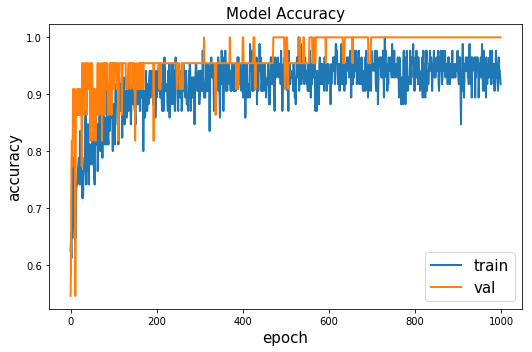

In [34]:
fig = plt.figure(figsize=(7.5,5))
plt.plot(df['acc'], linewidth=2.0)
plt.plot(df['val_acc'], linewidth=2.0)
plt.title('Model Accuracy', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'val'], loc='lower right', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

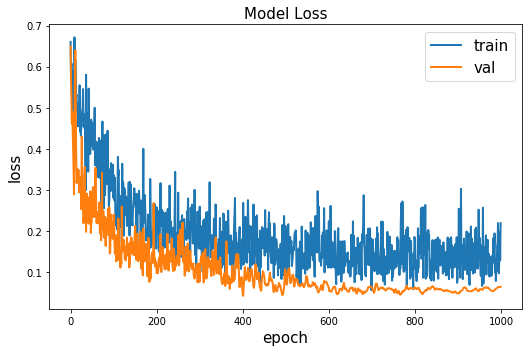

In [35]:
fig = plt.figure(figsize=(7.5,5))
plt.plot(df['loss'], linewidth=2.0)
plt.plot(df['val_loss'], linewidth=2.0)
plt.title('Model Loss', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'val'], loc='upper right', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()